In [2]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm, chi2, nbinom, logistic
from matplotlib import pyplot as plt
from NBinomRandomDataGenerator import NBinomRandomDataGenerator
import scipy.linalg as la
import warnings
import pandas as pd
from scipy.stats import gaussian_kde
from tqdm import tqdm

In [3]:
class NegativeBinomialAnalysis:
    def __init__(self, generate_plots=True):
        self.generate_plots=generate_plots
        return None

    def generate_data(self, true_beta=np.array([1, -4e-5]), n=10000, x_loc=30000, x_scale=100000):
        self.true_beta = true_beta
        self.n = n
        self.generator = NBinomRandomDataGenerator(size=n, x_distribution='uniform', beta=self.true_beta, x_loc=x_loc, x_scale=x_scale)
        self.data = self.generator.createVaryingCensoredData(generate_plots=self.generate_plots)
        # Organize data
        self.x = self.data["Desired Starting Salary ($)"]
        self.y = self.data["Rejected Job Applications"]
        self.x = self.x.to_numpy()
        self.y = self.y.to_numpy()

    def ell(self, b):
        # This is equivalent to the sigmoid function
        p = logistic.cdf(b[0] + b[1]*self.x)

        # Generate mask
        censored_points = self.data['Censored'] == 1
        uncensored_points = ~censored_points

        # Calculate censored and uncensored portions of the likelihood function
        uncensored_portion = nbinom.logpmf(self.y[uncensored_points], 1, p[uncensored_points])
        censored_portion = nbinom.logsf(self.y[censored_points] - 1, 1, p[censored_points]) # TODO: Should it be self.y[censored_points]? or that -1?
        # NOTE: It seems like it should be y-1, but the results are worse

        # Handle nan values by outputting a very negative value
        uncensored_portion = np.nan_to_num(uncensored_portion, nan=-1e6, posinf=-1e6, neginf=-1e6)
        censored_portion = np.nan_to_num(censored_portion, nan=-1e6, posinf=-1e6, neginf=-1e6)

        Q = np.zeros_like(p)
        Q[censored_points] = censored_portion
        Q[uncensored_points] = uncensored_portion

        return -np.mean(Q)
    
    def tobit_likelihood(self, b):

        xb = b[1] + b[2]*self.x
        alpha = (self.y - xb)  / b[0]

        # Generate mask
        censored_points = self.data['Censored'] == 1
        uncensored_points = ~censored_points

        # Calculate censored and uncensored portions of the likelihood function
        uncensored_portion = np.log((1/b[0])*(norm.pdf(alpha[uncensored_points])))
        censored_portion = norm.logsf((alpha[censored_points]))

        # Handle nan values by outputting a very negative value
        uncensored_portion = np.nan_to_num(uncensored_portion, nan=-1e6, posinf=-1e6, neginf=-1e6)
        censored_portion = np.nan_to_num(censored_portion, nan=-1e6, posinf=-1e6, neginf=-1e6)

        Q = np.zeros_like(alpha)
        Q[censored_points] = censored_portion
        Q[uncensored_points] = uncensored_portion

        return -np.mean(Q)
        

    def solve_negbin(self, suppress_output=False):

        warnings.simplefilter('ignore')
        # Find solution using scipy's minimize tools
        sol = opt.minimize(self.ell, x0=np.array([0, 0]), method='BFGS', options={'disp': not suppress_output})
        if not suppress_output:
            print(sol)
        # Save the coefficient vector and variance matrix
        self.beta_negbin = sol.x
        self.V = sol.hess_inv # NOTE: Since the likelihood function is defined as negative, we don't need the negative sign to calculate V
        return self.beta_negbin, self.V


    def solve_tobit(self, suppress_output=False):
        warnings.simplefilter('ignore')
        bounds = ((0, 500),(-1, 1), (-1,1))

        # b0 is std_dev, b1 is beta0, b2 is beta1
        sol = opt.differential_evolution(self.tobit_likelihood, x0=np.array([100, 0.5, 0.5]), bounds=bounds)
        if not suppress_output:
            print(sol)
        self.beta_tobit = sol.x
        # In this case the marginal effect is just self.beta_tobit[2]
        return self.beta_tobit
    
    def E_Y(self, b, x): # The expected value of Y, given beta and x
        return np.exp(-1*(b[0] + b[1]*x))

    def d_E_Y(self, b, x): # The derivative of E_Y wrt x
        return -1*b[1] * np.exp(-1*(b[0] + b[1]*x))

    def find_marginal_effects(self, graph_results=True):
        self.me_negbin = self.d_E_Y(self.beta_negbin, self.x)
        self.me_tobit = np.ones_like(self.x) * self.beta_tobit[2]
        self.me_true = self.d_E_Y(self.true_beta, self.x)

        # Graph the results
        if graph_results:
            plt.title("Marginal Effects")
            plt.plot(self.x, self.me_negbin, 'b,', label="NegBin")
            plt.plot(self.x, self.me_tobit, 'r,', label="Tobit")
            plt.plot(self.x, self.me_true, 'g,', label="True effect")
            plt.xlabel("x")
            plt.ylabel(" $\partial \mathbb{E}[y]$ / $\partial x$")
            # Create proxy artists for the legend
            legend_handles = [
                plt.Line2D([], [], marker='o', color='blue', linestyle='', markersize=6, label='NegBin'),
                plt.Line2D([], [], marker='o', color='red', linestyle='', markersize=6, label='Tobit'),
                plt.Line2D([], [], marker='o', color='green', linestyle='', markersize=6, label='True Effect')
            ]
            # Add the legend using the proxy artists
            plt.legend(handles=legend_handles)

            plt.show()
            
        return self.me_negbin, self.me_tobit, self.me_true
    
    def Wald(self, R, b, r, alpha=0.05, suppress_output=True):
        W = self.n*((R@b - r).T @ la.inv(R@self.V@(R.T))@(R@b-r))
        p_value = 1 - chi2.cdf(x=W, df=np.linalg.matrix_rank(R))

        if not suppress_output:
            print(f"Wald statistic: {W}")
            print(f"P value: {p_value}")
            print(f"Alpha: {alpha}")

            if p_value < alpha:
                print("Significance found: H_0 rejected")
            else:
                print("Failed to reject")

        return W, p_value

  0%|          | 0/100 [00:00<?, ?it/s]

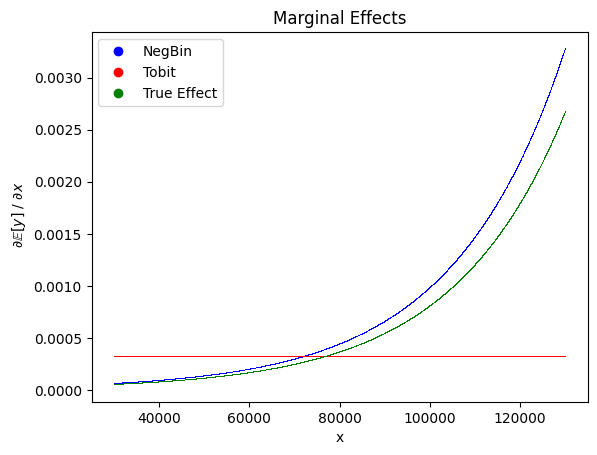

100%|██████████| 100/100 [05:47<00:00,  3.47s/it]


In [3]:
# Test the object
n_list = 10 ** np.arange(1, 5)
true_betas = []
negbin_coeffs = []
standard_errors = []
tobit_coeffs = []
p_value = []
avg_me_negbin = np.zeros(100)
avg_me_tobit = np.zeros(100)
avg_me_truth = np.zeros(100)
n = 10000

for i in tqdm(range(100)):
    graph_results = False
    if i == 0:
        graph_results = True
    
    analysis = NegativeBinomialAnalysis(generate_plots=False)
    analysis.generate_data(n=n)
    analysis.solve_negbin(suppress_output=True)
    analysis.solve_tobit(suppress_output=True)
    me_negbin, me_tobit, me_truth = analysis.find_marginal_effects(graph_results=graph_results)

    avg_me_negbin[i] = (np.mean(me_negbin))
    avg_me_tobit[i] = (np.mean(me_tobit))
    avg_me_truth[i] = (np.mean(me_truth))


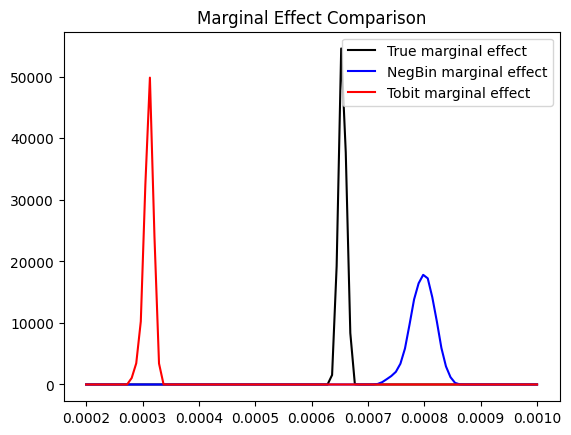

In [ ]:
# Maybe graph the results
# Make a KDE with NegBin Coefficients
domain = np.linspace(2e-4, 1e-3, 100)
kde_negbin = gaussian_kde(avg_me_negbin).evaluate(domain)
kde_tobit = gaussian_kde(avg_me_tobit).evaluate(domain)
kde_truth = gaussian_kde(avg_me_truth).evaluate(domain)
plt.plot(domain, kde_truth, 'k-', label="True marginal effect")
plt.plot(domain, kde_negbin, 'b-', label="NegBin marginal effect")
plt.plot(domain, kde_tobit, 'r-', label="Tobit marginal effect")
plt.title("Marginal Effect Comparison")
plt.legend(loc="upper right")
plt.show()

# Is this estimator consistent?

In [ ]:
# Make a table for various values of n
results = pd.DataFrame()
n_list = [10, 100, 1000, 10000, 50000, 60000, 70000, 80000, 90000, 100000, 150000, 200000]
true_betas = []
negbin_coeffs = []
standard_errors = []
tobit_coeffs = []
p_value = []
test = NegativeBinomialAnalysis(generate_plots=False)
for n in tqdm(n_list):
    test.generate_data(n=n)
    test.solve_negbin(suppress_output=True)
    test.solve_tobit(suppress_output=True)
    me_negbin, me_tobit, me_truth = test.find_marginal_effects(graph_results=False)

    true_betas.append(test.true_beta[1])
    negbin_coeffs.append(test.beta_negbin[1])
    standard_errors.append(np.sqrt( (1/n) * test.V[1,1]))

    #Extract the p value for beta1
    W, p = test.Wald(R=np.array([[0,1]]), b=test.beta_negbin, r=true_betas[-1])
    p_value.append(p)

results = pd.DataFrame({
    'N': n_list,
    'True Coefficient': true_betas,
    'NegBin Coefficient': negbin_coeffs,
    'Std. Error': standard_errors,
    'P value': p_value
})


  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [02:55<00:00, 14.59s/it]


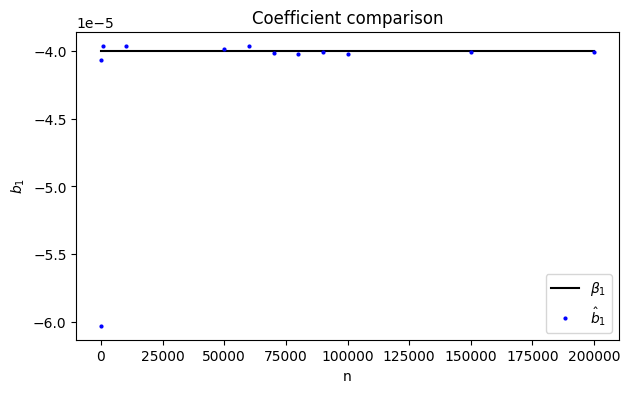

,N,True Coefficient,NegBin Coefficient,Std. Error,P value,Reject
0,10,-0.00004,-0.000060,9.872360e-06,0.039709,True
1,100,-0.00004,-0.000041,4.349394e-06,0.889043,False
2,1000,-0.00004,-0.000040,4.789652e-07,0.388862,False
3,10000,-0.00004,-0.000040,4.471430e-07,0.385013,False
4,50000,-0.00004,-0.000040,1.950990e-07,0.459475,False
5,60000,-0.00004,-0.000040,1.808061e-07,0.046654,True
6,70000,-0.00004,-0.000040,1.706818e-07,0.343829,False
7,80000,-0.00004,-0.000040,1.555671e-07,0.223703,False
8,90000,-0.00004,-0.000040,1.501371e-07,0.761609,False
9,100000,-0.00004,-0.000040,1.382806e-07,0.198429,False


In [10]:
fig, axs = plt.subplots(1, figsize=(7,4))
axs.plot(results['N'], results['True Coefficient'], 'k-', markersize=2, label=r"$ \beta_1 $")
axs.plot(results['N'], results['NegBin Coefficient'], 'bo', markersize=2, label=r"$\hat b_1$")
axs.legend()
axs.set_xlabel("n")
axs.set_ylabel("$b_1$")
axs.set_title("Coefficient comparison")
plt.show()
results['Reject'] = results['P value'] < 0.05
results

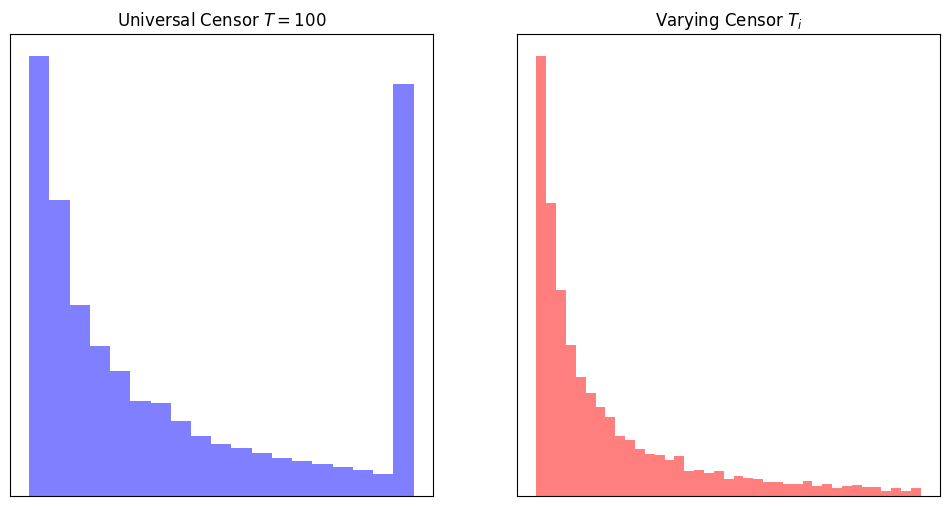

984

In [ ]:
# Create a histogram for the slides
pizza = NBinomRandomDataGenerator(size=10000)
data1 = pizza.createUniversallyCensoredData(T = 100)
data2 = pizza.createVaryingCensoredData(percent_censored=0.01)

data1

# plt.hist(data['Rejected Job Applications'], bins=20)

fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].hist(data1['Rejected Job Applications'], bins=np.arange(1, 21) * 5, density=True, color="blue", alpha=0.5)
axs[1].hist(data2['Rejected Job Applications'], bins=np.arange(1, 41) * 5, density=True, color="red", alpha=0.5)
axs[0].set_title("Universal Censor $T = 100$")
axs[1].set_title("Varying Censor $T_i$")
axs[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
axs[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


plt.show()
data2['Rejected Job Applications'].max()

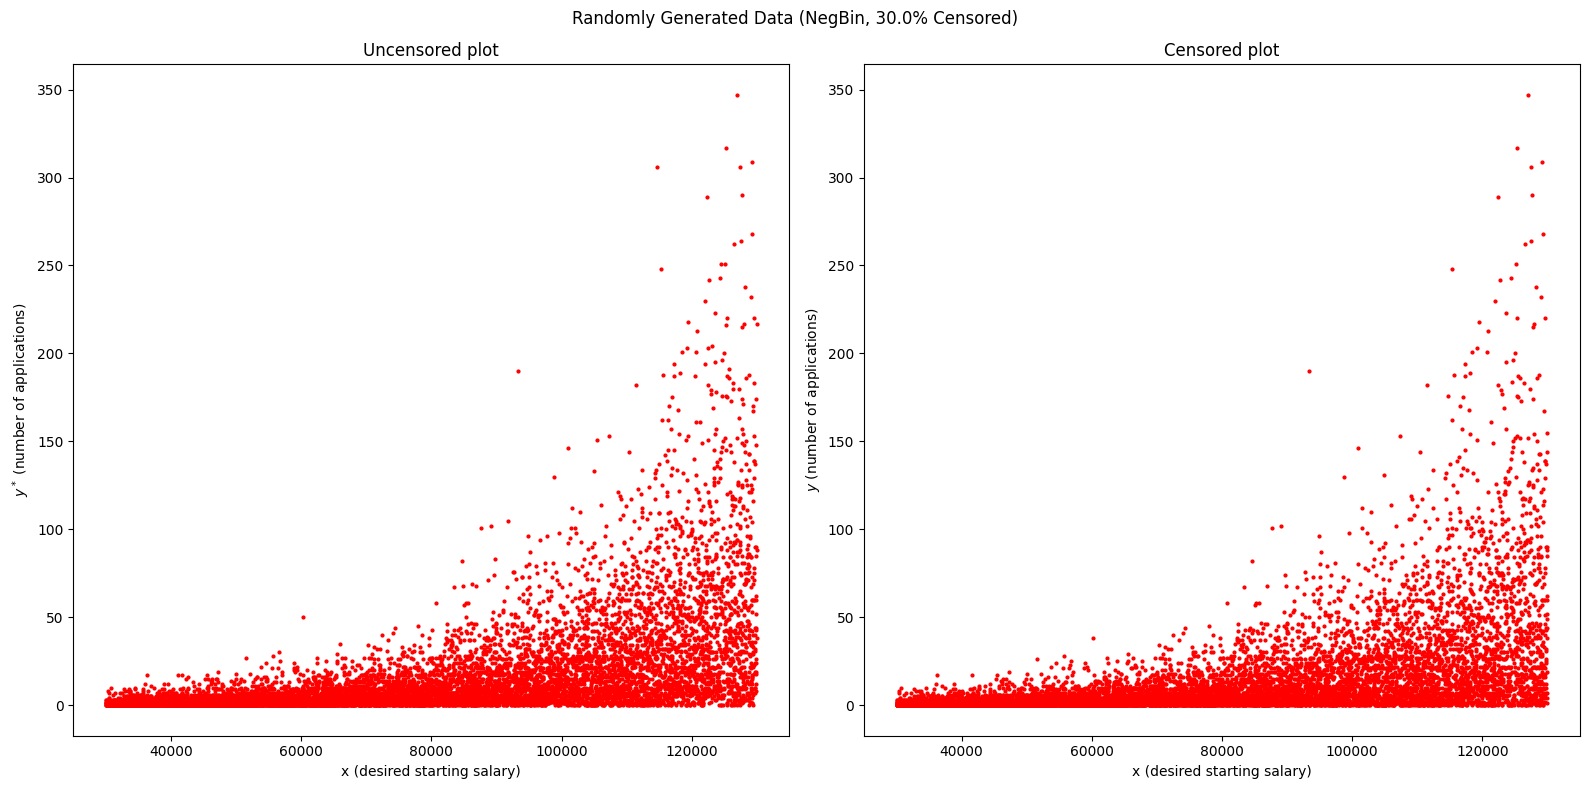

         Current function value: 2.442243
         Iterations: 12
         Function evaluations: 258
         Gradient evaluations: 82
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2.44224287085429
        x: [ 7.900e-01 -4.007e-05]
      nit: 12
      jac: [-5.924e-04 -3.074e+01]
 hess_inv: [[ 1.592e+01 -1.707e-04]
            [-1.707e-04  2.034e-09]]
     nfev: 258
     njev: 82
             message: Optimization terminated successfully.
             success: True
                 fun: 3.4242054010712977
                   x: [ 2.645e+01 -9.570e-01  3.191e-04]
                 nit: 24
                nfev: 1189
          population: [[ 2.645e+01 -9.570e-01  3.244e-04]
                       [ 3.105e+01 -9.558e-01  4.101e-04]
                       ...
                       [ 2.797e+01  6.766e-01  3.073e-04]
                       [ 2.418e+01 -6.585e-01  3.135e-04]]
 population_energies: [ 3.424e+00  3.460e+00 ...  3

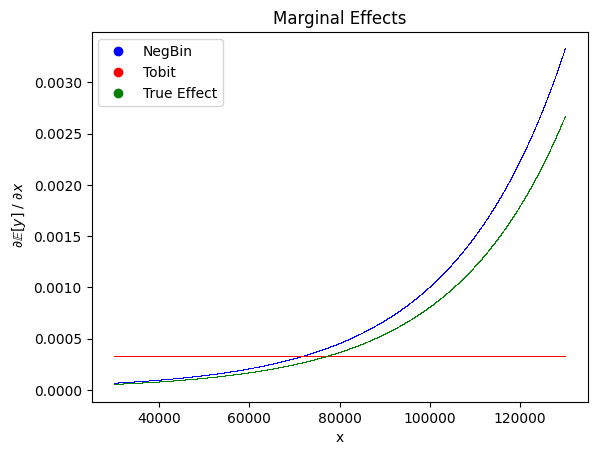

In [6]:
one_example = NegativeBinomialAnalysis(generate_plots=True)
one_example.generate_data(n=10000)
one_example.solve_negbin(suppress_output=False)
one_example.solve_tobit(suppress_output=False)
me_negbin, me_tobit, me_truth = one_example.find_marginal_effects(graph_results=True)